In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import mlflow
from mlflow.tracking import MlflowClient
import optuna
import os

from TMDP import TMDP
from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *

from RiverSwim import *
from CurriculumMPI import CurriculumMPI

In [2]:
#River Swim Environment
nS = 50
uniform_restart = True


small = 5e-3
large = 1.
nA = 2
gamma = 0.99

original_mu = np.zeros(nS)
original_mu[1] = 1.
xi = np.ones(nS)/(nS-2)
xi[0] = 0
xi[-1] = 0

if uniform_restart:
    mu = xi
else:
    mu = original_mu


episodes = 16000000
n_trials = 30
checkpoint_step=10000
test_episodes = 10000
discount_tau = True
param_decay=False
debug = False

lam = 1
experiment_results = []
tests_returns = []
tests_lens = []
exp_taus = []

In [3]:
run_name = f"CurrMPI_{uniform_restart}"

mlflow.set_tracking_uri(MLFLOW_URI)
experiment_name = f"RiverSwim_{nS}_{uniform_restart}_optuna"
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

label = run_name.split("_")[0]

In [4]:
tau = 0.2

epochs = 3
final_temp=1
temp = 1
check_convergence=True
biased=False

In [5]:
set_policy_seed(seed)
env = RiverSwim(nS, mu, small=small, large=large, seed=None)

# Environment independent configuration
tmdp = TMDP(env, xi, tau=tau, 
            gamma=gamma, discount_tau=discount_tau,
            xi_schedule=river_swim_uniform_curr_xi)
tmdp.update_tau(tau)


Current seed for result reproducibility: 227239994775268251833616569255594568897


In [6]:

def objective(trial):
    with mlflow.start_run(nested=True):
        global episodes
        # Parameter space optimization
        model_lr = trial.suggest_float("model_lr", 1e-4, 0.5, log=True)
        pol_lr = trial.suggest_float("pol_lr", 1e-4, 0.5, log=True)
        batch_size = trial.suggest_categorical('batch_size', [1, 2, 4, 8])
        #lam = trial.suggest_float("lam", 0., 1., log=False)
        #temp = trial.suggest_float("temp", 1, 3, log=False)

        tmdp.update_tau(tau) # Reset the teleport rate 
        
        curr_MPI = CurriculumMPI(tmdp, checkpoint_step=checkpoint_step)
        curr_MPI.train(model_lr, pol_lr, batch_size=batch_size, 
                        lam=lam, temp=temp, final_temp=final_temp,
                        episodes=episodes, check_convergence=check_convergence,
                        param_decay=param_decay, biased=biased,
                        debug=debug, epochs=epochs, original_mu=original_mu)   
        
        avg_return = np.average(curr_MPI.reward_records[-30:])/batch_size
        
        test_policies = test_policies_len(tmdp, curr_MPI.thetas, test_episodes, 1, mu=original_mu)
        test_policies_return = np.mean(test_policies[0][-30:])
        test_pol_len = np.mean(test_policies[1][-30:])

        mlflow.log_metric("Avg Return", avg_return)
        mlflow.log_metric("Test Return", test_policies_return)
        mlflow.log_metric("Test Policy Length", test_pol_len)
        
        mlflow.log_params({
            "model_lr": model_lr,
            "pol_lr": pol_lr,
            "batch_size": batch_size,
            "temp": temp,
        })

        mlflow.set_tags(tags={
            "Algorithm": "CurriculumMPI",
            "Environment": tmdp.env.__class__.__name__,
            "nS": nS,
            "nA": nA,
            "gamma": gamma,
            "tau": tau,
            "episodes": curr_MPI.episodes,
            "checkpoint_step": curr_MPI.checkpoint_step,
            "epochs": epochs,
            "final_temp": final_temp,
            "discount_tau": discount_tau,
            "param_decay": param_decay,
        })

    return test_policies_return


In [7]:

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    
    mlflow.log_params(study.best_params)
    
    curr_MPI = CurriculumMPI(tmdp, checkpoint_step=checkpoint_step)

    # Get the best parameters
    model_lr = study.best_params["model_lr"]
    pol_lr = study.best_params["pol_lr"]
    batch_size = study.best_params["batch_size"]
    #lam = study.best_params["lam"]
    #temp = study.best_params["temp"]
    
    # Train the best model
    curr_MPI.train(model_lr, pol_lr, batch_size=batch_size, 
                        lam=lam, temp=temp, final_temp=final_temp,
                        episodes=episodes, check_convergence=check_convergence,
                        param_decay=param_decay, biased=biased,
                        debug=debug, epochs=epochs, original_mu=original_mu)  
    
    mlflow.set_tags(tags={
            "Algorithm": "CurriculumMPI",
            "Environment": tmdp.env.__class__.__name__,
            "nS": nS,
            "nA": nA,
            "gamma": gamma,
            "tau": tau,
            "episodes": curr_MPI.episodes,
            "checkpoint_step": curr_MPI.checkpoint_step,
            "epochs": epochs,
            "final_temp": final_temp,
            "discount_tau": discount_tau,
            "param_decay": param_decay,
            "model_lr": model_lr,
            "pol_lr": pol_lr,
            "batch_size": batch_size,
            "temp": temp,
        })


[I 2024-06-19 00:02:22,055] A new study created in memory with name: no-name-5110b77a-8965-4441-a64b-12cb4f78b979


Episode: 100000 reward: 0.8 tau 0.2 batch_len 1 teleports 544
Episode: 200000 reward: 0.8 tau 0.2 batch_len 1 teleports 171
Episode: 300000 reward: 1.6 tau 0.2 batch_len 2 teleports 669
Episode: 400000 reward: 0.808 tau 0.2 batch_len 3 teleports 420
Episode: 500000 reward: 0.804 tau 0.2 batch_len 2 teleports 180
Episode: 600000 reward: 0.8 tau 0.2 batch_len 1 teleports 234
Episode: 700000 reward: 1.6 tau 0.2 batch_len 2 teleports 214
Episode: 800000 reward: 0.0 tau 0.2 batch_len 0 teleports 186
Episode: 900000 reward: 1.6 tau 0.2 batch_len 2 teleports 335
Episode: 1000000 reward: 1.6 tau 0.2 batch_len 2 teleports 698
Episode: 1100000 reward: 0.8 tau 0.2 batch_len 1 teleports 563
Episode: 1200000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 302
Episode: 1300000 reward: 1.6 tau 0.2 batch_len 2 teleports 460
Episode: 1400000 reward: 1.6 tau 0.2 batch_len 2 teleports 375
Episode: 1500000 reward: 1.604 tau 0.2 batch_len 3 teleports 502
Episode: 1600000 reward: 1.6 tau 0.2 batch_

[I 2024-06-19 00:11:33,228] Trial 0 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.00043050463438215587, 'pol_lr': 0.00016229130861678827, 'batch_size': 4}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 3.2119999999999997 tau 0.2 batch_len 7 teleports 892
Episode: 200000 reward: 1.608 tau 0.2 batch_len 4 teleports 385
Episode: 300000 reward: 2.404 tau 0.2 batch_len 4 teleports 1294
Episode: 400000 reward: 3.208 tau 0.2 batch_len 6 teleports 744
Episode: 500000 reward: 0.8 tau 0.2 batch_len 1 teleports 60
Episode: 600000 reward: 0.8 tau 0.2 batch_len 1 teleports 13
Episode: 700000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 115
Episode: 800000 reward: 3.2119999999999997 tau 0.2 batch_len 7 teleports 795
Episode: 900000 reward: 4.8 tau 0.2 batch_len 6 teleports 1086
Episode: 1000000 reward: 4.004 tau 0.2 batch_len 6 teleports 627
Episode: 1100000 reward: 4.008 tau 0.2 batch_len 7 teleports 717
Episode: 1200000 reward: 3.2039999999999997 tau 0.2 batch_len 5 teleports 865
Episode: 1300000 reward: 3.2120000000000006 tau 0.2 batch_len 7 teleports 323
Episode: 1400000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 527
Episode: 1500000 reward: 3.

[I 2024-06-19 00:17:32,787] Trial 1 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.23364019366286315, 'pol_lr': 0.00038870970933549377, 'batch_size': 8}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.0 tau 0.19999 batch_len 0 teleports 111
Episode: 200000 reward: 0.0 tau 0.19983 batch_len 0 teleports 117
Episode: 300000 reward: 0.0 tau 0.19923 batch_len 0 teleports 64
Episode: 400000 reward: 0.0 tau 0.19885 batch_len 0 teleports 91
Episode: 500000 reward: 0.0 tau 0.19885 batch_len 0 teleports 76
Episode: 600000 reward: 0.0 tau 0.1963 batch_len 0 teleports 25
Episode: 700000 reward: 0.0 tau 0.18789 batch_len 0 teleports 25
Episode: 800000 reward: 0.0 tau 0.17093 batch_len 0 teleports 3
Episode: 900000 reward: 0.0 tau 0.15281 batch_len 0 teleports 40
Episode: 1000000 reward: 0.0 tau 0.12862 batch_len 0 teleports 15
Episode: 1100000 reward: 0.0 tau 0.09432 batch_len 0 teleports 8
Episode: 1200000 reward: 0.0 tau 0.0561 batch_len 0 teleports 3
Episode: 1300000 reward: 0.0 tau 0.01506 batch_len 0 teleports 0
Episode: 1400000 reward: 0.0 tau 0.00154 batch_len 0 teleports 0
Episode: 1500000 reward: 0.0 tau 0.00121 batch_len 0 teleports 0
Converged to the original

[I 2024-06-19 00:28:07,405] Trial 2 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0001442983668023252, 'pol_lr': 0.02176439374143263, 'batch_size': 1}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 1.604 tau 0.2 batch_len 3 teleports 268
Episode: 200000 reward: 0.8 tau 0.2 batch_len 1 teleports 131
Episode: 300000 reward: 0.8062914 tau 0.19772 batch_len 2 teleports 270
Episode: 400000 reward: 1.6185800000000001 tau 0.19071 batch_len 2 teleports 69
Episode: 500000 reward: 0.8215071 tau 0.18258 batch_len 2 teleports 39
Episode: 600000 reward: 0.0 tau 0.17426 batch_len 0 teleports 45
Episode: 700000 reward: 0.0 tau 0.16578 batch_len 0 teleports 96
Episode: 800000 reward: 0.8470743 tau 0.15714 batch_len 2 teleports 92
Episode: 900000 reward: 1.7085407 tau 0.14786 batch_len 3 teleports 263
Episode: 1000000 reward: 0.0 tau 0.13866 batch_len 0 teleports 13
Episode: 1100000 reward: 0.8750133 tau 0.12934 batch_len 2 teleports 184
Episode: 1200000 reward: 0.0 tau 0.11947 batch_len 0 teleports 8
Episode: 1300000 reward: 0.0133749 tau 0.10834 batch_len 3 teleports 58
Episode: 1400000 reward: 0.013559700000000001 tau 0.09602 batch_len 3 teleports 37
Episode: 1500000 re

[I 2024-06-19 00:34:53,882] Trial 3 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0017465452730673582, 'pol_lr': 0.06443295455339987, 'batch_size': 4}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.8 tau 0.2 batch_len 1 teleports 161
Episode: 200000 reward: 0.004 tau 0.2 batch_len 1 teleports 362
Episode: 300000 reward: 0.0 tau 0.19999 batch_len 0 teleports 49
Episode: 400000 reward: 0.0 tau 0.19999 batch_len 0 teleports 971
Episode: 500000 reward: 0.80001 tau 0.19999 batch_len 1 teleports 254
Episode: 600000 reward: 0.0 tau 0.19999 batch_len 0 teleports 489
Episode: 700000 reward: 0.0 tau 0.19999 batch_len 0 teleports 48
Episode: 800000 reward: 0.0 tau 0.19999 batch_len 0 teleports 21
Episode: 900000 reward: 0.80003 tau 0.19997 batch_len 1 teleports 624
Episode: 1000000 reward: 0.80004 tau 0.19996 batch_len 1 teleports 84
Episode: 1100000 reward: 0.0 tau 0.19993 batch_len 0 teleports 12
Episode: 1200000 reward: 0.0 tau 0.19984 batch_len 0 teleports 325
Episode: 1300000 reward: 0.80029 tau 0.19971 batch_len 1 teleports 23
Episode: 1400000 reward: 0.80064 tau 0.19936 batch_len 1 teleports 222
Episode: 1500000 reward: 0.0 tau 0.199 batch_len 0 teleports 7


[I 2024-06-19 00:41:15,645] Trial 4 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0003217225504791643, 'pol_lr': 0.00038937201755897773, 'batch_size': 2}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.8 tau 0.2 batch_len 1 teleports 95
Episode: 200000 reward: 0.0 tau 0.2 batch_len 0 teleports 21
Episode: 300000 reward: 0.0 tau 0.18047 batch_len 0 teleports 1
Episode: 400000 reward: 0.00420115 tau 0.15977 batch_len 1 teleports 50
Episode: 500000 reward: 0.0 tau 0.13898 batch_len 0 teleports 14
Episode: 600000 reward: 0.0 tau 0.11333 batch_len 0 teleports 21
Episode: 700000 reward: 0.0046045999999999995 tau 0.07908 batch_len 1 teleports 17
Episode: 800000 reward: 0.96017 tau 0.03983 batch_len 1 teleports 3
Episode: 900000 reward: 0.0049725 tau 0.0055 batch_len 1 teleports 0
Converged to the original problem, episode 925148
Episode: 1000000 reward: 0.005 tau 0 batch_len 1 teleports 0
Episode: 1100000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1200000 reward: 0.005 tau 0 batch_len 1 teleports 0
Episode: 1300000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1400000 reward: 0.005 tau 0 batch_len 1 teleports 0
Episode: 1500000 reward: 0.0 tau 0 batch_

[I 2024-06-19 00:49:30,385] Trial 5 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.00530923562938204, 'pol_lr': 0.03348908296416568, 'batch_size': 2}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 992
Episode: 200000 reward: 3.2040000000000006 tau 0.2 batch_len 5 teleports 1148
Episode: 300000 reward: 3.2 tau 0.2 batch_len 4 teleports 586
Episode: 400000 reward: 0.0 tau 0.2 batch_len 0 teleports 141
Episode: 500000 reward: 3.2079999999999997 tau 0.2 batch_len 6 teleports 1000
Episode: 600000 reward: 0.8 tau 0.2 batch_len 1 teleports 103
Episode: 700000 reward: 0.0 tau 0.2 batch_len 0 teleports 33
Episode: 800000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 168
Episode: 900000 reward: 0.8 tau 0.2 batch_len 1 teleports 451
Episode: 1000000 reward: 4.8 tau 0.2 batch_len 6 teleports 200
Episode: 1100000 reward: 1.604 tau 0.2 batch_len 3 teleports 316
Episode: 1200000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 135
Episode: 1300000 reward: 1.604 tau 0.2 batch_len 3 teleports 386
Episode: 1400000 reward: 3.208 tau 0.2 batch_len 6 teleports 411
Episode: 1500000 reward: 0.8 tau 0.2 batch_le

[I 2024-06-19 00:56:30,135] Trial 6 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0001207857787348962, 'pol_lr': 0.003329580697218009, 'batch_size': 8}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.0 tau 0.19989 batch_len 0 teleports 38
Episode: 200000 reward: 0.0 tau 0.19956 batch_len 0 teleports 143
Episode: 300000 reward: 0.0 tau 0.19913 batch_len 0 teleports 29
Episode: 400000 reward: 0.0 tau 0.19828 batch_len 0 teleports 7
Episode: 500000 reward: 0.0 tau 0.19766 batch_len 0 teleports 568
Episode: 600000 reward: 0.0 tau 0.19689 batch_len 0 teleports 462
Episode: 700000 reward: 0.0 tau 0.19567 batch_len 0 teleports 666
Episode: 800000 reward: 0.0 tau 0.19449 batch_len 0 teleports 217
Episode: 900000 reward: 0.0 tau 0.19314 batch_len 0 teleports 233
Episode: 1000000 reward: 0.0 tau 0.19149 batch_len 0 teleports 14
Episode: 1100000 reward: 0.0 tau 0.18966 batch_len 0 teleports 144
Episode: 1200000 reward: 0.0 tau 0.18787 batch_len 0 teleports 116
Episode: 1300000 reward: 0.0 tau 0.18582 batch_len 0 teleports 82
Episode: 1400000 reward: 0.0 tau 0.18363 batch_len 0 teleports 137
Episode: 1500000 reward: 0.0 tau 0.18075 batch_len 0 teleports 1
Episode: 160

[I 2024-06-19 01:04:10,024] Trial 7 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.041429641956604674, 'pol_lr': 0.00013773161834217183, 'batch_size': 1}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 3.208 tau 0.2 batch_len 6 teleports 763
Episode: 200000 reward: 0.004 tau 0.2 batch_len 1 teleports 480
Episode: 300000 reward: 0.8 tau 0.2 batch_len 1 teleports 27
Episode: 400000 reward: 4.007999999999999 tau 0.2 batch_len 7 teleports 598
Episode: 500000 reward: 4.0040000000000004 tau 0.2 batch_len 6 teleports 816
Episode: 600000 reward: 4.803999999999999 tau 0.2 batch_len 7 teleports 880
Episode: 700000 reward: 0.8 tau 0.2 batch_len 1 teleports 327
Episode: 800000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 760
Episode: 900000 reward: 2.4080000000000004 tau 0.2 batch_len 5 teleports 860
Episode: 1000000 reward: 4.0 tau 0.2 batch_len 5 teleports 400
Episode: 1100000 reward: 0.0 tau 0.2 batch_len 0 teleports 82
Episode: 1200000 reward: 4.004 tau 0.2 batch_len 6 teleports 1392
Episode: 1300000 reward: 4.804 tau 0.2 batch_len 7 teleports 798
Episode: 1400000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 747
Episode: 1500000 reward: 3.2 tau

[I 2024-06-19 01:13:22,543] Trial 8 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.05381152533109753, 'pol_lr': 0.00015270509864745104, 'batch_size': 8}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 1.604 tau 0.2 batch_len 3 teleports 849
Episode: 200000 reward: 1.604 tau 0.2 batch_len 3 teleports 601
Episode: 300000 reward: 1.604 tau 0.2 batch_len 3 teleports 298
Episode: 400000 reward: 1.604 tau 0.2 batch_len 3 teleports 677
Episode: 500000 reward: 1.604 tau 0.2 batch_len 3 teleports 151
Episode: 600000 reward: 1.604 tau 0.2 batch_len 3 teleports 498
Episode: 700000 reward: 0.0 tau 0.2 batch_len 0 teleports 51
Episode: 800000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 61
Episode: 900000 reward: 0.8 tau 0.2 batch_len 1 teleports 165
Episode: 1000000 reward: 0.8 tau 0.2 batch_len 1 teleports 80
Episode: 1100000 reward: 0.8 tau 0.2 batch_len 1 teleports 87
Episode: 1200000 reward: 0.0040143 tau 0.19714 batch_len 1 teleports 91
Episode: 1300000 reward: 2.44947 tau 0.18351 batch_len 3 teleports 219
Episode: 1400000 reward: 0.0 tau 0.16875 batch_len 0 teleports 19
Episode: 1500000 reward: 1.69673125 tau 0.15375 batch_len 3 teleports 179
Episode: 1

[I 2024-06-19 01:19:53,388] Trial 9 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.001154736305378336, 'pol_lr': 0.0018599248877558762, 'batch_size': 4}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.8 tau 0.2 batch_len 1 teleports 1057
Episode: 200000 reward: 0.8 tau 0.2 batch_len 1 teleports 301
Episode: 300000 reward: 0.0 tau 0.2 batch_len 0 teleports 290
Episode: 400000 reward: 1.6 tau 0.2 batch_len 2 teleports 197
Episode: 500000 reward: 0.8 tau 0.2 batch_len 1 teleports 18
Episode: 600000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 314
Episode: 700000 reward: 0.8 tau 0.2 batch_len 1 teleports 86
Episode: 800000 reward: 0.0 tau 0.2 batch_len 0 teleports 16
Episode: 900000 reward: 1.604 tau 0.2 batch_len 3 teleports 264
Episode: 1000000 reward: 0.004 tau 0.2 batch_len 1 teleports 138
Episode: 1100000 reward: 0.8 tau 0.2 batch_len 1 teleports 94
Episode: 1200000 reward: 0.8 tau 0.2 batch_len 1 teleports 144
Episode: 1300000 reward: 0.0 tau 0.1976 batch_len 0 teleports 73
Episode: 1400000 reward: 0.0 tau 0.18703 batch_len 0 teleports 129
Episode: 1500000 reward: 0.8308536 tau 0.17328 batch_len 2 teleports 112
Episode: 1600000 reward: 1.68094

[I 2024-06-19 01:26:26,079] Trial 10 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0008843415876710179, 'pol_lr': 0.0014777406242886303, 'batch_size': 4}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 1010
Episode: 200000 reward: 2.416 tau 0.2 batch_len 7 teleports 595
Episode: 300000 reward: 2.4040000000000004 tau 0.2 batch_len 4 teleports 106
Episode: 400000 reward: 0.0 tau 0.19997 batch_len 0 teleports 190
Episode: 500000 reward: 0.0 tau 0.19997 batch_len 0 teleports 51
Episode: 600000 reward: 2.40009 tau 0.19997 batch_len 3 teleports 278
Episode: 700000 reward: 1.60406015 tau 0.19997 batch_len 3 teleports 328
Episode: 800000 reward: 5.600209999999999 tau 0.19997 batch_len 7 teleports 942
Episode: 900000 reward: 0.80403015 tau 0.19997 batch_len 2 teleports 396
Episode: 1000000 reward: 3.2081203 tau 0.19997 batch_len 6 teleports 838
Episode: 1100000 reward: 4.800179999999999 tau 0.19997 batch_len 6 teleports 524
Episode: 1200000 reward: 5.600560000000001 tau 0.19992 batch_len 7 teleports 839
Episode: 1300000 reward: 1.60016 tau 0.19992 batch_len 2 teleports 339
Episode: 1400000 reward: 4.0004 tau 0.19992 batc

[I 2024-06-19 01:32:07,011] Trial 11 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.24277044769242334, 'pol_lr': 0.0006128390750894169, 'batch_size': 8}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.80407035 tau 0.19993 batch_len 2 teleports 87
Episode: 200000 reward: 1.60708 tau 0.19646 batch_len 2 teleports 538
Episode: 300000 reward: 3.2346 tau 0.19135 batch_len 4 teleports 437
Episode: 400000 reward: 2.4467912 tau 0.18576 batch_len 4 teleports 146
Episode: 500000 reward: 5.7463 tau 0.1791 batch_len 7 teleports 375
Episode: 600000 reward: 3.3177938000000005 tau 0.17262 batch_len 6 teleports 352
Episode: 700000 reward: 0.83507 tau 0.16493 batch_len 1 teleports 109
Episode: 800000 reward: 1.68987415 tau 0.15717 batch_len 3 teleports 173
Episode: 900000 reward: 0.85129 tau 0.14871 batch_len 1 teleports 44
Episode: 1000000 reward: 1.7270925000000001 tau 0.14075 batch_len 4 teleports 72
Episode: 1100000 reward: 2.6229908 tau 0.13146 batch_len 7 teleports 145
Episode: 1200000 reward: 4.3969926 tau 0.12148 batch_len 6 teleports 99
Episode: 1300000 reward: 1.795073 tau 0.11135 batch_len 6 teleports 109
Episode: 1400000 reward: 0.917082 tau 0.1009 batch_len 5 t

[I 2024-06-19 01:38:29,240] Trial 12 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.2635567336965848, 'pol_lr': 0.3517168140948269, 'batch_size': 8}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.8 tau 0.2 batch_len 1 teleports 217
Episode: 200000 reward: 0.8 tau 0.2 batch_len 1 teleports 627
Episode: 300000 reward: 0.004 tau 0.2 batch_len 1 teleports 58
Episode: 400000 reward: 1.604 tau 0.2 batch_len 3 teleports 237
Episode: 500000 reward: 0.804 tau 0.2 batch_len 2 teleports 371
Episode: 600000 reward: 0.0 tau 0.2 batch_len 0 teleports 93
Episode: 700000 reward: 1.6 tau 0.2 batch_len 2 teleports 349
Episode: 800000 reward: 1.6 tau 0.2 batch_len 2 teleports 163
Episode: 900000 reward: 1.6 tau 0.2 batch_len 2 teleports 211
Episode: 1000000 reward: 0.8 tau 0.2 batch_len 1 teleports 146
Episode: 1100000 reward: 0.8 tau 0.2 batch_len 1 teleports 116
Episode: 1200000 reward: 0.80016 tau 0.19984 batch_len 1 teleports 52
Episode: 1300000 reward: 0.0 tau 0.19938 batch_len 0 teleports 205
Episode: 1400000 reward: 0.80521605 tau 0.19879 batch_len 2 teleports 73
Episode: 1500000 reward: 0.0 tau 0.1973 batch_len 0 teleports 7
Episode: 1600000 reward: 1.6145062 tau

[I 2024-06-19 01:44:54,742] Trial 13 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.014716337834182882, 'pol_lr': 0.00046149061619883637, 'batch_size': 4}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 1.6 tau 0.2 batch_len 2 teleports 700
Episode: 200000 reward: 0.804 tau 0.2 batch_len 2 teleports 649
Episode: 300000 reward: 0.0 tau 0.2 batch_len 0 teleports 194
Episode: 400000 reward: 0.808 tau 0.2 batch_len 3 teleports 466
Episode: 500000 reward: 1.604 tau 0.2 batch_len 3 teleports 656
Episode: 600000 reward: 0.0 tau 0.2 batch_len 0 teleports 30
Episode: 700000 reward: 0.808 tau 0.2 batch_len 3 teleports 168
Episode: 800000 reward: 1.6 tau 0.2 batch_len 2 teleports 328
Episode: 900000 reward: 1.6 tau 0.2 batch_len 2 teleports 372
Episode: 1000000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 323
Episode: 1100000 reward: 1.60002 tau 0.19999 batch_len 2 teleports 363
Episode: 1200000 reward: 0.0 tau 0.19999 batch_len 0 teleports 1
Episode: 1300000 reward: 0.00400005 tau 0.19999 batch_len 1 teleports 322
Episode: 1400000 reward: 0.0 tau 0.19999 batch_len 0 teleports 111
Episode: 1500000 reward: 0.80401005 tau 0.19999 batch_len 2 teleports 251
Episod

[I 2024-06-19 01:54:03,770] Trial 14 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.005174609073383737, 'pol_lr': 0.00011129893649217969, 'batch_size': 4}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 3.2040400499999997 tau 0.19999 batch_len 5 teleports 443
Episode: 200000 reward: 3.2081203 tau 0.19997 batch_len 6 teleports 1609
Episode: 300000 reward: 1.6041203 tau 0.19994 batch_len 3 teleports 642
Episode: 400000 reward: 4.80036 tau 0.19994 batch_len 6 teleports 968
Episode: 500000 reward: 0.80006 tau 0.19994 batch_len 1 teleports 89
Episode: 600000 reward: 1.60098 tau 0.19951 batch_len 2 teleports 157
Episode: 700000 reward: 0.80148 tau 0.19852 batch_len 1 teleports 48
Episode: 800000 reward: 2.4114 tau 0.1962 batch_len 3 teleports 169
Episode: 900000 reward: 4.0344999999999995 tau 0.1931 batch_len 5 teleports 244
Episode: 1000000 reward: 4.0607500000000005 tau 0.18785 batch_len 5 teleports 282
Episode: 1100000 reward: 4.096892799999999 tau 0.18144 batch_len 6 teleports 248
Episode: 1200000 reward: 2.47506 tau 0.17498 batch_len 3 teleports 253
Episode: 1300000 reward: 2.4991984 tau 0.16832 batch_len 4 teleports 157
Episode: 1400000 reward: 0.0 tau 0.16004 

[I 2024-06-19 02:00:19,352] Trial 15 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.4646290316715625, 'pol_lr': 0.0060439185866747154, 'batch_size': 8}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.0 tau 0.2 batch_len 0 teleports 222
Episode: 200000 reward: 0.0 tau 0.2 batch_len 0 teleports 189
Episode: 300000 reward: 0.0 tau 0.2 batch_len 0 teleports 206
Episode: 400000 reward: 0.0 tau 0.2 batch_len 0 teleports 107
Episode: 500000 reward: 0.0 tau 0.19996 batch_len 0 teleports 82
Episode: 600000 reward: 0.0 tau 0.19944 batch_len 0 teleports 73
Episode: 700000 reward: 0.00401025 tau 0.19795 batch_len 1 teleports 116
Episode: 800000 reward: 0.0 tau 0.19469 batch_len 0 teleports 5
Episode: 900000 reward: 0.80971 tau 0.19029 batch_len 1 teleports 124
Episode: 1000000 reward: 0.0 tau 0.17757 batch_len 0 teleports 2
Episode: 1100000 reward: 0.83751 tau 0.16249 batch_len 1 teleports 94
Episode: 1200000 reward: 0.8593500000000001 tau 0.14065 batch_len 1 teleports 31
Episode: 1300000 reward: 0.0 tau 0.108 batch_len 0 teleports 12
Episode: 1400000 reward: 0.0 tau 0.05314 batch_len 0 teleports 3
Episode: 1500000 reward: 0.0049732 tau 0.00536 batch_len 1 teleports 1

[I 2024-06-19 02:08:27,848] Trial 16 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.06409081440927565, 'pol_lr': 0.0008108994122273794, 'batch_size': 2}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.0 tau 0.19994 batch_len 0 teleports 65
Episode: 200000 reward: 0.0 tau 0.19987 batch_len 0 teleports 19
Episode: 300000 reward: 0.0 tau 0.19968 batch_len 0 teleports 181
Episode: 400000 reward: 0.0 tau 0.19933 batch_len 0 teleports 218
Episode: 500000 reward: 0.0 tau 0.19894 batch_len 0 teleports 286
Episode: 600000 reward: 0.0 tau 0.19819 batch_len 0 teleports 55
Episode: 700000 reward: 0.0 tau 0.19664 batch_len 0 teleports 83
Episode: 800000 reward: 0.0 tau 0.19481 batch_len 0 teleports 68
Episode: 900000 reward: 0.0 tau 0.19277 batch_len 0 teleports 41
Episode: 1000000 reward: 0.0 tau 0.18985 batch_len 0 teleports 17
Episode: 1100000 reward: 0.0 tau 0.18668 batch_len 0 teleports 8
Episode: 1200000 reward: 0.0 tau 0.1824 batch_len 0 teleports 180
Episode: 1300000 reward: 0.0 tau 0.17768 batch_len 0 teleports 140
Episode: 1400000 reward: 0.0 tau 0.17059 batch_len 0 teleports 190
Episode: 1500000 reward: 0.0 tau 0.16123 batch_len 0 teleports 3
Episode: 1600000

[I 2024-06-19 02:17:47,323] Trial 17 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.016311342578828998, 'pol_lr': 0.00027966947402105686, 'batch_size': 1}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 3.208 tau 0.2 batch_len 6 teleports 2218
Episode: 200000 reward: 0.0 tau 0.2 batch_len 0 teleports 1
Episode: 300000 reward: 4.0040000000000004 tau 0.2 batch_len 6 teleports 793
Episode: 400000 reward: 0.8 tau 0.2 batch_len 1 teleports 120
Episode: 500000 reward: 1.6 tau 0.2 batch_len 2 teleports 276
Episode: 600000 reward: 0.0 tau 0.2 batch_len 0 teleports 9
Episode: 700000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 597
Episode: 800000 reward: 0.0 tau 0.2 batch_len 0 teleports 73
Episode: 900000 reward: 0.80322 tau 0.19678 batch_len 1 teleports 75
Episode: 1000000 reward: 4.03995 tau 0.19201 batch_len 5 teleports 328
Episode: 1100000 reward: 0.81655245 tau 0.18751 batch_len 2 teleports 107
Episode: 1200000 reward: 0.0 tau 0.18274 batch_len 0 teleports 114
Episode: 1300000 reward: 0.82632105 tau 0.17779 batch_len 2 teleports 145
Episode: 1400000 reward: 2.4928019999999997 tau 0.1732 batch_len 6 teleports 205
Episode: 1500000 reward: 1.6633200000000

[I 2024-06-19 02:23:47,089] Trial 18 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0024254335533299017, 'pol_lr': 0.008087569312544287, 'batch_size': 8}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 236
Episode: 200000 reward: 0.004 tau 0.2 batch_len 1 teleports 36
Episode: 300000 reward: 0.0 tau 0.2 batch_len 0 teleports 63
Episode: 400000 reward: 1.604 tau 0.2 batch_len 3 teleports 125
Episode: 500000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 604
Episode: 600000 reward: 0.0 tau 0.2 batch_len 0 teleports 167
Episode: 700000 reward: 0.8 tau 0.2 batch_len 1 teleports 170
Episode: 800000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 356
Episode: 900000 reward: 0.0 tau 0.19998 batch_len 0 teleports 27
Episode: 1000000 reward: 0.80009 tau 0.19991 batch_len 1 teleports 160
Episode: 1100000 reward: 2.40039 tau 0.19987 batch_len 3 teleports 362
Episode: 1200000 reward: 0.80069 tau 0.19931 batch_len 1 teleports 16
Episode: 1300000 reward: 2.4038700000000004 tau 0.19871 batch_len 3 teleports 85
Episode: 1400000 reward: 1.6081503500000003 tau 0.19793 batch_len 3 teleports 47
Episode: 1500000 r

[I 2024-06-19 02:30:13,829] Trial 19 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0003993185714570853, 'pol_lr': 0.0011457764946910824, 'batch_size': 4}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.808 tau 0.2 batch_len 3 teleports 542
Episode: 200000 reward: 0.8 tau 0.2 batch_len 1 teleports 93
Episode: 300000 reward: 1.604 tau 0.2 batch_len 3 teleports 572
Episode: 400000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 425
Episode: 500000 reward: 0.0 tau 0.2 batch_len 0 teleports 368
Episode: 600000 reward: 0.0 tau 0.2 batch_len 0 teleports 88
Episode: 700000 reward: 0.0 tau 0.2 batch_len 0 teleports 88
Episode: 800000 reward: 0.80001 tau 0.19999 batch_len 1 teleports 73
Episode: 900000 reward: 1.60002 tau 0.19999 batch_len 2 teleports 405
Episode: 1000000 reward: 1.60002 tau 0.19999 batch_len 2 teleports 202
Episode: 1100000 reward: 0.80001 tau 0.19999 batch_len 1 teleports 121
Episode: 1200000 reward: 2.40006 tau 0.19998 batch_len 3 teleports 203
Episode: 1300000 reward: 0.80403015 tau 0.19997 batch_len 2 teleports 217
Episode: 1400000 reward: 1.60006 tau 0.19997 batch_len 2 teleports 142
Episode: 1500000 reward: 0.80004 tau 0.19996 batch_le

[I 2024-06-19 02:36:18,684] Trial 20 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.1281305123777532, 'pol_lr': 0.00021296266968098907, 'batch_size': 4}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.0 tau 0.19998 batch_len 0 teleports 29
Episode: 200000 reward: 0.0 tau 0.19977 batch_len 0 teleports 242
Episode: 300000 reward: 0.0 tau 0.19905 batch_len 0 teleports 40
Episode: 400000 reward: 0.0 tau 0.19905 batch_len 0 teleports 255
Episode: 500000 reward: 0.0 tau 0.19905 batch_len 0 teleports 18
Episode: 600000 reward: 0.0 tau 0.18565 batch_len 0 teleports 5
Episode: 700000 reward: 0.0 tau 0.16677 batch_len 0 teleports 75
Episode: 800000 reward: 0.0 tau 0.14633 batch_len 0 teleports 17
Episode: 900000 reward: 0.0 tau 0.12065 batch_len 0 teleports 55
Episode: 1000000 reward: 0.0 tau 0.0867 batch_len 0 teleports 1
Episode: 1100000 reward: 0.0 tau 0.04985 batch_len 0 teleports 4
Episode: 1200000 reward: 0.0 tau 0.01037 batch_len 0 teleports 0
Episode: 1300000 reward: 0.0 tau 0.00148 batch_len 0 teleports 0
Episode: 1400000 reward: 0.0 tau 0.00106 batch_len 0 teleports 0
Converged to the original problem, episode 1411645
Episode: 1500000 reward: 0.0 tau 0 batc

[I 2024-06-19 02:47:43,480] Trial 21 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0001527181028336053, 'pol_lr': 0.037060985202751286, 'batch_size': 1}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.0 tau 0.19996 batch_len 0 teleports 53
Episode: 200000 reward: 0.0 tau 0.19982 batch_len 0 teleports 144
Episode: 300000 reward: 0.0 tau 0.19937 batch_len 0 teleports 13
Episode: 400000 reward: 0.0 tau 0.19694 batch_len 0 teleports 34
Episode: 500000 reward: 0.0 tau 0.18703 batch_len 0 teleports 9
Episode: 600000 reward: 0.0 tau 0.16113 batch_len 0 teleports 48
Episode: 700000 reward: 0.0 tau 0.12915 batch_len 0 teleports 13
Episode: 800000 reward: 0.0 tau 0.08931 batch_len 0 teleports 15
Episode: 900000 reward: 0.0 tau 0.03266 batch_len 0 teleports 0
Converged to the original problem, episode 988595
Episode: 1000000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1100000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1200000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1300000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1400000 reward: 0.005 tau 0 batch_len 1 teleports 0
Episode: 1500000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1

[I 2024-06-19 02:58:58,280] Trial 22 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0004243243132858733, 'pol_lr': 0.01277059509997108, 'batch_size': 1}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.0 tau 0.19998 batch_len 0 teleports 10
Episode: 200000 reward: 0.0 tau 0.19971 batch_len 0 teleports 1
Episode: 300000 reward: 0.0 tau 0.19713 batch_len 0 teleports 115
Episode: 400000 reward: 0.0 tau 0.19713 batch_len 0 teleports 0
Episode: 500000 reward: 0.0 tau 0.19713 batch_len 0 teleports 245
Episode: 600000 reward: 0.0 tau 0.1893 batch_len 0 teleports 13
Episode: 700000 reward: 0.0 tau 0.17369 batch_len 0 teleports 74
Episode: 800000 reward: 0.0 tau 0.15485 batch_len 0 teleports 33
Episode: 900000 reward: 0.0 tau 0.13473 batch_len 0 teleports 6
Episode: 1000000 reward: 0.0 tau 0.11169 batch_len 0 teleports 20
Episode: 1100000 reward: 0.0 tau 0.07953 batch_len 0 teleports 21
Episode: 1200000 reward: 0.0 tau 0.04164 batch_len 0 teleports 0
Episode: 1300000 reward: 0.0 tau 0.00717 batch_len 0 teleports 0
Episode: 1400000 reward: 0.0 tau 0.0018 batch_len 0 teleports 0
Episode: 1500000 reward: 0.0 tau 0.00124 batch_len 0 teleports 0
Converged to the original 

[I 2024-06-19 03:10:26,295] Trial 23 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.00010463806381780016, 'pol_lr': 0.08266396590483029, 'batch_size': 1}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.0 tau 0.19997 batch_len 0 teleports 242
Episode: 200000 reward: 0.0 tau 0.19982 batch_len 0 teleports 19
Episode: 300000 reward: 0.0 tau 0.19929 batch_len 0 teleports 6
Episode: 400000 reward: 0.0 tau 0.19842 batch_len 0 teleports 12
Episode: 500000 reward: 0.0 tau 0.19641 batch_len 0 teleports 30
Episode: 600000 reward: 0.0 tau 0.18912 batch_len 0 teleports 29
Episode: 700000 reward: 0.0 tau 0.17254 batch_len 0 teleports 73
Episode: 800000 reward: 0.0 tau 0.15044 batch_len 0 teleports 84
Episode: 900000 reward: 0.0 tau 0.12549 batch_len 0 teleports 42
Episode: 1000000 reward: 0.0 tau 0.09414 batch_len 0 teleports 37
Episode: 1100000 reward: 0.0 tau 0.05108 batch_len 0 teleports 20
Episode: 1200000 reward: 0.0 tau 0.00994 batch_len 0 teleports 1
Episode: 1300000 reward: 0.0 tau 0.00114 batch_len 0 teleports 0
Converged to the original problem, episode 1335376
Episode: 1400000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1500000 reward: 0.0 tau 0 batch_le

[I 2024-06-19 03:21:05,000] Trial 24 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0002105177419611446, 'pol_lr': 0.01642502335801367, 'batch_size': 1}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.0 tau 0.19998 batch_len 0 teleports 64
Episode: 200000 reward: 0.0 tau 0.1999 batch_len 0 teleports 68
Episode: 300000 reward: 0.0 tau 0.1997 batch_len 0 teleports 42
Episode: 400000 reward: 0.0 tau 0.19873 batch_len 0 teleports 177
Episode: 500000 reward: 0.0 tau 0.19553 batch_len 0 teleports 42
Episode: 600000 reward: 0.0 tau 0.18542 batch_len 0 teleports 49
Episode: 700000 reward: 0.0 tau 0.1733 batch_len 0 teleports 68
Episode: 800000 reward: 0.0 tau 0.14674 batch_len 0 teleports 58
Episode: 900000 reward: 0.0 tau 0.10834 batch_len 0 teleports 3
Episode: 1000000 reward: 0.0 tau 0.03926 batch_len 0 teleports 0
Converged to the original problem, episode 1060520
Episode: 1100000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1200000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1300000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1400000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode: 1500000 reward: 0.0 tau 0 batch_len 0 teleports 0
Episode

[I 2024-06-19 03:31:29,969] Trial 25 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0006849717998893329, 'pol_lr': 0.0030283469260827607, 'batch_size': 1}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 1.6 tau 0.2 batch_len 2 teleports 190
Episode: 200000 reward: 3.2 tau 0.2 batch_len 4 teleports 243
Episode: 300000 reward: 5.615609999999999 tau 0.19777 batch_len 7 teleports 319
Episode: 400000 reward: 2.41761 tau 0.19413 batch_len 3 teleports 263
Episode: 500000 reward: 1.61818 tau 0.19091 batch_len 2 teleports 145
Episode: 600000 reward: 0.0 tau 0.18741 batch_len 0 teleports 21
Episode: 700000 reward: 3.2681601 tau 0.18398 batch_len 5 teleports 255
Episode: 800000 reward: 3.2906137 tau 0.18042 batch_len 7 teleports 306
Episode: 900000 reward: 3.29244 tau 0.17689 batch_len 4 teleports 356
Episode: 1000000 reward: 5.79145 tau 0.17265 batch_len 7 teleports 341
Episode: 1100000 reward: 0.83135 tau 0.16865 batch_len 1 teleports 77
Episode: 1200000 reward: 3.34268 tau 0.16433 batch_len 4 teleports 169
Episode: 1300000 reward: 0.84023 tau 0.15977 batch_len 1 teleports 15
Episode: 1400000 reward: 3.3860038999999995 tau 0.15561 batch_len 6 teleports 169
Episode: 1500

[I 2024-06-19 03:37:21,925] Trial 26 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.002857962352041116, 'pol_lr': 0.21986857943459528, 'batch_size': 8}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.0 tau 0.2 batch_len 0 teleports 550
Episode: 200000 reward: 0.8 tau 0.2 batch_len 1 teleports 421
Episode: 300000 reward: 0.0 tau 0.2 batch_len 0 teleports 15
Episode: 400000 reward: 0.8 tau 0.2 batch_len 1 teleports 91
Episode: 500000 reward: 0.0 tau 0.2 batch_len 0 teleports 12
Episode: 600000 reward: 0.0 tau 0.1867 batch_len 0 teleports 73
Episode: 700000 reward: 0.0042392 tau 0.15216 batch_len 1 teleports 6
Episode: 800000 reward: 0.88358 tau 0.11642 batch_len 1 teleports 29
Episode: 900000 reward: 0.0046658 tau 0.06684 batch_len 1 teleports 5
Episode: 1000000 reward: 0.0 tau 0.00816 batch_len 0 teleports 0
Converged to the original problem, episode 1025159
Episode: 1100000 reward: 0.005 tau 0 batch_len 1 teleports 0
Episode: 1200000 reward: 0.005 tau 0 batch_len 1 teleports 0
Episode: 1300000 reward: 0.005 tau 0 batch_len 1 teleports 0
Episode: 1400000 reward: 0.005 tau 0 batch_len 1 teleports 0
Episode: 1500000 reward: 1.0 tau 0 batch_len 1 teleports 0
E

[I 2024-06-19 03:45:30,944] Trial 27 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.01019487131692327, 'pol_lr': 0.0036591667263870357, 'batch_size': 2}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.0 tau 0.2 batch_len 0 teleports 32
Episode: 200000 reward: 4.004 tau 0.2 batch_len 6 teleports 720
Episode: 300000 reward: 4.8 tau 0.2 batch_len 6 teleports 357
Episode: 400000 reward: 3.20304 tau 0.19924 batch_len 4 teleports 371
Episode: 500000 reward: 0.80289 tau 0.19711 batch_len 1 teleports 4
Episode: 600000 reward: 3.22076 tau 0.19481 batch_len 4 teleports 452
Episode: 700000 reward: 5.652780000000001 tau 0.19246 batch_len 7 teleports 511
Episode: 800000 reward: 4.05610205 tau 0.18959 batch_len 6 teleports 315
Episode: 900000 reward: 0.0 tau 0.18659 batch_len 0 teleports 15
Episode: 1000000 reward: 3.268280249999999 tau 0.18395 batch_len 5 teleports 486
Episode: 1100000 reward: 0.81917 tau 0.18083 batch_len 1 teleports 113
Episode: 1200000 reward: 3.29956715 tau 0.17819 batch_len 7 teleports 669
Episode: 1300000 reward: 1.6581093 tau 0.17507 batch_len 4 teleports 146
Episode: 1400000 reward: 0.0 tau 0.17195 batch_len 0 teleports 134
Episode: 1500000 rewa

[I 2024-06-19 03:51:40,752] Trial 28 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.0005808131972464708, 'pol_lr': 0.1348165598731821, 'batch_size': 8}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 2.4000000000000004 tau 0.2 batch_len 3 teleports 148
Episode: 200000 reward: 0.0 tau 0.2 batch_len 0 teleports 134
Episode: 300000 reward: 1.6 tau 0.2 batch_len 2 teleports 265
Episode: 400000 reward: 1.604 tau 0.2 batch_len 3 teleports 147
Episode: 500000 reward: 0.8 tau 0.2 batch_len 1 teleports 310
Episode: 600000 reward: 1.6 tau 0.2 batch_len 2 teleports 95
Episode: 700000 reward: 1.60312 tau 0.19844 batch_len 2 teleports 138
Episode: 800000 reward: 0.80545 tau 0.19455 batch_len 1 teleports 107
Episode: 900000 reward: 1.6209 tau 0.18955 batch_len 2 teleports 226
Episode: 1000000 reward: 1.6313 tau 0.18435 batch_len 2 teleports 101
Episode: 1100000 reward: 2.46225 tau 0.17925 batch_len 3 teleports 158
Episode: 1200000 reward: 0.0 tau 0.17395 batch_len 0 teleports 100
Episode: 1300000 reward: 0.0041579500000000005 tau 0.16841 batch_len 1 teleports 46
Episode: 1400000 reward: 1.67578 tau 0.16211 batch_len 2 teleports 96
Episode: 1500000 reward: 1.69248065 tau 0

[I 2024-06-19 03:58:02,268] Trial 29 finished with value: 0.005000000000000001 and parameters: {'model_lr': 0.00021409665910266976, 'pol_lr': 0.02887133064601536, 'batch_size': 4}. Best is trial 0 with value: 0.005000000000000001.


Episode: 100000 reward: 0.005 tau 0.0 batch_len 1 teleports 0
Episode: 200000 reward: 0.01 tau 0.0 batch_len 2 teleports 0
Episode: 300000 reward: 0.005 tau 0.0 batch_len 1 teleports 0
Episode: 400000 reward: 0.0 tau 0.0 batch_len 0 teleports 0
Episode: 500000 reward: 0.005 tau 0.0 batch_len 1 teleports 0
Episode: 600000 reward: 0.005 tau 0.0 batch_len 1 teleports 0
Episode: 700000 reward: 0.01 tau 0.0 batch_len 2 teleports 0
Episode: 800000 reward: 0.01 tau 0.0 batch_len 2 teleports 0
Episode: 900000 reward: 0.015 tau 0.0 batch_len 3 teleports 0
Episode: 1000000 reward: 0.01 tau 0.0 batch_len 2 teleports 0
Episode: 1100000 reward: 0.005 tau 0.0 batch_len 1 teleports 0
Episode: 1200000 reward: 0.01 tau 0.0 batch_len 2 teleports 0
Episode: 1300000 reward: 0.01 tau 0.0 batch_len 2 teleports 0
Episode: 1400000 reward: 0.01 tau 0.0 batch_len 2 teleports 0
Episode: 1500000 reward: 0.015 tau 0.0 batch_len 3 teleports 0
Episode: 1600000 reward: 0.005 tau 0.0 batch_len 1 teleports 0
Episode: 1

In [8]:
study.best_params

{'model_lr': 0.00043050463438215587,
 'pol_lr': 0.00016229130861678827,
 'batch_size': 4}

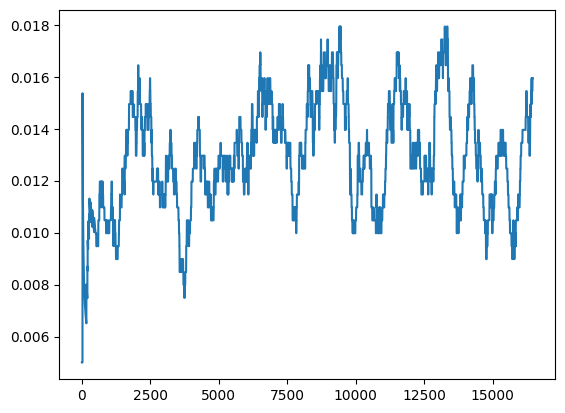

In [9]:
import matplotlib.pyplot as plt
reward_records = curr_MPI.reward_records
# Generate recent 50 interval average
average_reward = []
scaled_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    scaled_reward.append(reward_records[idx]/batch_size)
    if idx < 500:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-499:idx+1]
    average_reward.append(np.average(avg_list)/batch_size)
# Plot
#plt.plot(scaled_reward)
plt.plot(average_reward[:-1])